# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>



Ouissal, Salima, Alexandre, Idriss, Elias

## Modules

In [1]:
# Modules de base
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Module relatif à Gurobi
from gurobipy import *

# Module csv
import csv
import matplotlib.pyplot as plt

## Préprocessing des données

Pour la suite de notre étude, on considère le modèle d'avion **Airbus A320**, qui dispose de **174** sièges. (La classe businees n'est pas prise en compte)


<img src="modele_avion.jpg" alt="Modèle de l'avion" width="400" height="600">

In [2]:
number_of_seats = 174

In [3]:
# Load the Excel file into a pandas DataFrame

df_21Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('../ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [4]:
# Displaying the data

df_07Nov.head()

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,1.0,NaN,NaN,00:55:00
1,2,NaN,1.0,NaN,00:00:00
2,3,1.0,NaN,NaN,01:15:00
3,4,1.0,1.0,NaN,03:15:00
4,5,1.0,NaN,NaN,00:00:00


In [5]:
# On choisit la df sur laquelle on va travailler

# df = df_21Oct
# df = df_22Oct
# df = df_23Oct
# df = df_24Oct
df = df_30Oct
# df = df_05Nov
# df = df_07Nov

In [6]:
# Groups : dict[int : List[int]]

Passagers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0

for group in df.itertuples():
    for j in range(2,5):
        if not pd.isna(group[j]):
            for k in range(int(group[j])):
                Passagers[i] = {'gender': j-2, 'group':group[1], 'transit': float('inf') }
                if group[5].hour*60 + group[5].minute != 0:
                    Passagers[i]['transit'] = group[5].hour*60 + group[5].minute
                if j == 2: number_f+=1
                elif j==3: number_m+=1
                else: number_d+=1

                i+=1    

Passagers

{1: {'gender': 0, 'group': 1, 'transit': inf},
 2: {'gender': 0, 'group': 1, 'transit': inf},
 3: {'gender': 1, 'group': 1, 'transit': inf},
 4: {'gender': 1, 'group': 1, 'transit': inf},
 5: {'gender': 0, 'group': 2, 'transit': inf},
 6: {'gender': 1, 'group': 3, 'transit': 60},
 7: {'gender': 2, 'group': 3, 'transit': 60},
 8: {'gender': 0, 'group': 4, 'transit': inf},
 9: {'gender': 0, 'group': 4, 'transit': inf},
 10: {'gender': 0, 'group': 4, 'transit': inf},
 11: {'gender': 0, 'group': 4, 'transit': inf},
 12: {'gender': 0, 'group': 5, 'transit': 115},
 13: {'gender': 0, 'group': 6, 'transit': inf},
 14: {'gender': 1, 'group': 6, 'transit': inf},
 15: {'gender': 1, 'group': 7, 'transit': inf},
 16: {'gender': 2, 'group': 7, 'transit': inf},
 17: {'gender': 1, 'group': 8, 'transit': inf},
 18: {'gender': 0, 'group': 9, 'transit': inf},
 19: {'gender': 0, 'group': 10, 'transit': inf},
 20: {'gender': 2, 'group': 10, 'transit': inf},
 21: {'gender': 0, 'group': 11, 'transit': 60},
 

In [7]:
# Number of rows and columns per row based on the airplane configuration
number_of_rows = 29  # Rows are 1-indexed from 1 to 29
seats_per_row = 6    # 6 seats per row (0,1,2,3,4,5)
number_of_seats = 174
weight_f = 70 # weight female
weight_m = 85 # weight male
weight_d = 92.5 # weight disabled

## Initialize the model

In [8]:
m = Model("airplane_seating")

# Weights is a dictionary mapping (i, j, k) to a weight, as discussed earlier

# Create decision variables for each seat and passenger
# The decision variable x will be a 3D dictionary with the keys being the row number,
# the seat within the row, and the unique identifier for each passenger.

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, seats_per_row + 1)
                    for k in range(1, len(Passagers)+1)}


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-06


## Constraints

In [9]:
# Each passenger has a seat
SEATSASSIGNMENTCONST = m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                             for i in range(1, number_of_rows + 1)
                                             for j in range(1, seats_per_row + 1)
                                             for k in range(1,len(Passagers)+1)]) == len(Passagers))


In [10]:
# Each passenger must have one seat
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, seats_per_row + 1) ]) == 1)
                                                for k in range(1,len(Passagers)+1) }


In [11]:
# Constraint Airplane Centrage

i_m = quicksum([weight_m * i* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])
i_f = quicksum([weight_m * i* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])
i_d = quicksum([weight_m * i* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

i_bary = (i_m + i_f +i_d)/( weight_m * number_m + weight_f * number_f + weight_d * number_d)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])
j_f = quicksum([weight_m * j* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])
j_d = quicksum([weight_m * j* AssignmenVarDict[(i, j, k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, seats_per_row+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

j_bary = (j_m + j_f + j_d)/( weight_m * number_m + weight_f * number_f + weight_d * number_d)

IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 4)
JMINBARYCONST = m.addConstr(3 <= j_bary)

## Objective Function

In [12]:
# Define the weights for the Manhattan distance
a = 0.9  # Weight for the row distance
b = 0.1  # Weight for the column distance

# Objective function to minimize the weighted sum of distances between all passengers in the same group
objective_groups = quicksum(
    a * abs(i1 - i2) + b * abs(j1 - j2) * AssignmenVarDict[(i1, j1, k1)] * AssignmenVarDict[(i2, j2, k2)]
    for i1 in range(1, number_of_rows + 1)
    for j1 in range(1, seats_per_row + 1)
    for i2 in range(1, number_of_rows + 1)
    for j2 in range(1, seats_per_row + 1)
    for k1 in Passagers.keys()
    for k2 in Passagers.keys()
    if Passagers[k1]['group'] == Passagers[k2]['group'] and k1 != k2
)

# Front rows (lower i) should have lower weight
objective_transit = quicksum( [AssignmenVarDict[(i, j, k)]* i*(1/Passagers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, seats_per_row+1 )
                      for k in range(1, len(Passagers)+1)
                      if Passagers[k]['transit'] != float('inf') ])

# Objective function for the Disabled to be placed in front and in a certain way
objective_disabled = quicksum( [AssignmenVarDict[(i, j, k)] + AssignmenVarDict[(i, j-1, k)] + AssignmenVarDict[(i+1, j-1, k)] + AssignmenVarDict[(i+1, j, k)] <= 1
                      for i in range(1, number_of_rows+1)
                      for j in range(1, seats_per_row+1 )
                      for k in range(1, len(Passagers)+1)
                      if Passagers[k]['gender'] == 2 ])

m.setObjective(objective_groups + objective_transit + objective_transit, GRB.MINIMIZE)

KeyError: (1, 0, 7)

## Optimize Model

In [ ]:
# Run optimization and suppress output
m.params.outputflag = 0 
m.optimize()

# If the model is infeasible or unbounded, turn off presolve and optimize again
if m.status in [GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED]:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

# Post-processing of results
if m.status == GRB.OPTIMAL:
    # Post-processing of results
    # Extract the seating arrangement from the model
    seating_arrangement = {}
    for i in range(1, number_of_rows + 1):
        for j in range(1, seats_per_row + 1):
            for k in Passagers.keys():
                if AssignmenVarDict[(i, j, k)].X > 0.5:  # Ensure the variable is part of the solution
                    seating_arrangement[(i, j)] = k
    print(f"Seating arrangement: {seating_arrangement}")
    print(f'Optimal objective value (z*): {round(m.objVal, 2)}')
else:
    print("Optimization was unsuccessful. Status code:", m.status)
    m.computeIIS()
    m.write("model.ilp")
    print("The infeasibility file has been written to 'model.ilp'")

Seating arrangement: {(1, 2): 126, (1, 5): 162, (1, 6): 133, (2, 2): 29, (2, 4): 42, (2, 5): 158, (3, 3): 56, (3, 4): 99, (3, 5): 10, (3, 6): 20, (4, 1): 49, (4, 2): 21, (4, 3): 74, (4, 4): 165, (4, 5): 130, (5, 1): 163, (5, 3): 26, (5, 4): 54, (5, 5): 103, (5, 6): 172, (6, 1): 154, (6, 2): 124, (6, 4): 82, (6, 5): 94, (7, 1): 91, (7, 2): 149, (7, 4): 171, (7, 5): 13, (7, 6): 63, (8, 2): 140, (8, 3): 100, (8, 4): 164, (9, 1): 125, (9, 2): 2, (9, 3): 155, (9, 4): 127, (9, 6): 160, (10, 1): 11, (10, 2): 83, (10, 4): 41, (10, 5): 57, (11, 3): 53, (11, 5): 129, (12, 1): 96, (12, 2): 38, (12, 3): 112, (13, 1): 138, (13, 2): 145, (13, 3): 161, (13, 4): 79, (13, 5): 117, (13, 6): 7, (14, 2): 167, (14, 3): 128, (14, 5): 134, (14, 6): 136, (15, 1): 146, (15, 3): 12, (15, 4): 156, (15, 5): 106, (16, 1): 47, (16, 2): 168, (16, 3): 22, (17, 1): 169, (17, 2): 143, (17, 3): 142, (17, 4): 62, (17, 6): 45, (18, 3): 64, (18, 5): 32, (19, 1): 121, (19, 2): 23, (19, 3): 150, (19, 6): 73, (20, 3): 115, (2

## Graphic Seating Arrangement

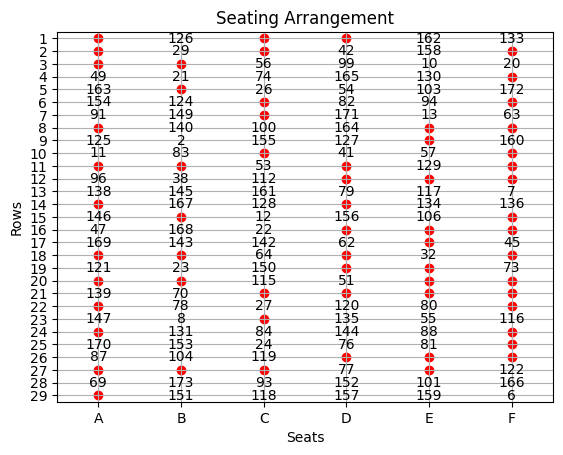

In [ ]:
# Define the dimensions of the airplane
number_of_rows = 29
seats_per_row = 6

# Define the seating arrangement
seating_arrangement = seating_arrangement

# Create a plot
fig, ax = plt.subplots()

# Plot the seating arrangement
for seat, Passengers in seating_arrangement.items():
    ax.text(seat[1], seat[0], Passengers, ha='center', va='center')

# Mark positions without passengers
for i in range(1, number_of_rows + 1):
    for j in range(1, seats_per_row + 1):
        if (i, j) not in seating_arrangement:
            ax.scatter(j, i, color='red')

# Set the limits and labels of the plot
ax.set_xlim(0.5, seats_per_row + 0.5)
ax.set_ylim(0.5, number_of_rows + 0.5)
ax.set_xticks(range(1, seats_per_row + 1))
ax.set_yticks(range(1, number_of_rows + 1))
ax.set_xticklabels([chr(65 + i) for i in range(seats_per_row)]) # permet de générer les lettres A,B,C,D,E,F grâce à chr()
ax.set_yticklabels(range(1, number_of_rows + 1))
ax.grid(True)

# Add labels and title
plt.xlabel('Seats')
plt.ylabel('Rows')
plt.title('Seating Arrangement')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to match the plane layout
plt.show()
